# Investments Project (Spring 2024)

**Authors:**
- Marc-Antoine Allard
- Adam Zinebi
- Paul Teiletche
- ...

**DUE Date: June 21 at 23:59**

In [1]:
from google.colab import drive

drive.mount('/content/drive')

%cd drive/MyDrive/inv/investments_project

Mounted at /content/drive
/content/drive/MyDrive/inv/investments_project


---
# Imports

In [2]:
import numpy as np
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import datetime
#import wrds
import seaborn as sns

---
# The Data

*Download monthly stock returns from CRSP from January 1, 1964, to December 31, 2023, for all common stocks traded on the NYSE and AMEX. Also, download the value-weighted CRSP market return and 1-month T-bill returns as a risk-free rate. Many of the relevant SQL requests or Python commands are found in the previous exercises covered earlier during the semester.*

In [3]:
data = pd.read_parquet('/content/drive/MyDrive/inv/investments_project/data/stock_data.parquet')

---
# Betting against Beta strategy (BaB)

*a) Compute the time-varying market βt,n for each stock by running monthly rolling 5-
year regressions of stock-specific excess returns on the excess market return. Require
at least 36 months of observations for each stock. Winsorize the beta at 5 and 95 %.*

In [7]:
import pandas as pd
import statsmodels.api as sm
from tqdm import tqdm
data = data.dropna(subset=['mcap_l', 'Rn_e', 'Rm_e']).copy()

# 1. Remove stocks with less than 60 observations
data['N'] = data.groupby(['permno'])['date'].transform('count')
data = data[data['N'] > 60].copy()
tqdm.pandas()

# 2. Function to calculate rolling beta using OLS regression
def calculate_rolling_beta(group, window=60, min_periods=36):
    group = group.sort_values('date')
    betas = pd.Series(index=group.index, dtype=float)
    for start in (range(len(group) - min_periods + 1)):
        end = start + window
        if end > len(group):
            end = len(group)
        subset = group.iloc[start:end]
        if len(subset) >= min_periods:
            X = sm.add_constant(subset['Rm_e'])
            y = subset['Rn_e']
            model = sm.OLS(y, X).fit()
            betas.iloc[end-1] = model.params['Rm_e']
    return betas

# Apply the rolling beta calculation to each group of 'permno'
data['beta'] = data.groupby('permno').progress_apply(calculate_rolling_beta).reset_index(level=0, drop=True)

# 3. Winsorize the beta at 5% and 95%
beta_5th = data['beta'].quantile(0.05)
beta_95th = data['beta'].quantile(0.95)
data['beta'] = data['beta'].clip(lower=beta_5th, upper=beta_95th)

# Drop the temporary 'N' column if no longer needed
data = data.drop(columns=['N'])


100%|██████████| 5922/5922 [45:39<00:00,  2.16it/s]


In [8]:
data.to_parquet('slow_part.parquet')


*b) At every month t, sort all stocks into deciles based on their beta (estimated using the most recent rolling window). Then compute monthly returns for 10 decile portfolios that equal weight all stocks in each decile. Plot the average annualized portfolio mean, standard deviation, and Sharpe ratios across the 10 deciles in three bar plots. Repeat for value-weighted decile portfolios. Summarize our findings. Is the evidence consistent with the CAPM?*

In [9]:
# 1. Quintiles
data = data.dropna(subset=['beta']).copy()
data['beta_Q'] = data.groupby('date')['beta'].transform(lambda x: pd.qcut(x, 10,labels=False, duplicates='drop'))

# 2. Market Weights within quintiles
data['vw_Q'] = data['mcap']/data.groupby(['date','beta_Q'])['mcap'].transform('sum')

# 3. VW Portfolios
data['beta_ret_vw'] = data['vw_Q']*data['Rn']
ret_vw = data.groupby(['date','beta_Q'])['beta_ret_vw'].sum().reset_index()
vw_ret_mean = ret_vw.groupby('beta_Q')['beta_ret_vw'].mean()

# 4. Equal-Weighted portfolios
ret_ew = data.groupby(['date','beta_Q'])['Rn'].mean().reset_index()
ew_ret_mean = ret_ew.groupby('beta_Q')['Rn'].mean()



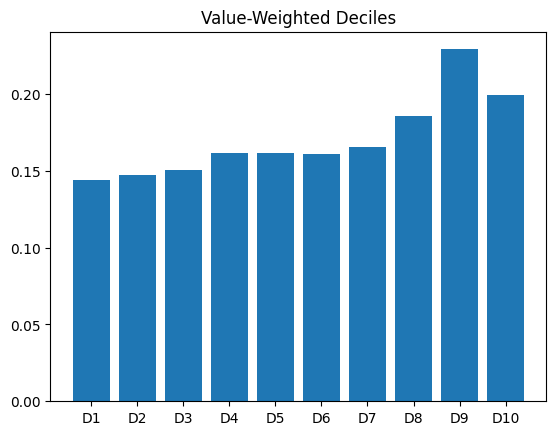

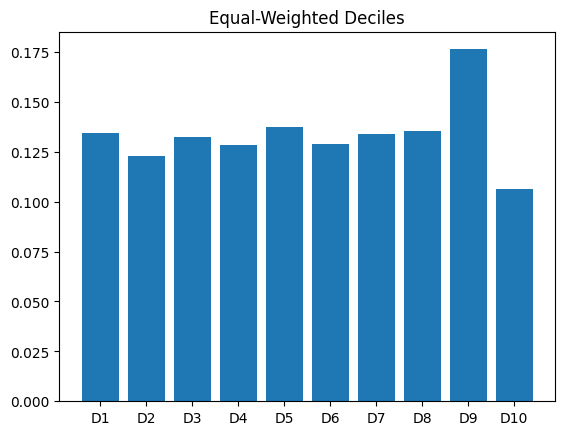

(<BarContainer object of 10 artists>,
 Text(0.5, 1.0, 'Equal-Weighted Deciles'),
 None)

In [10]:
# 5. Plot Histogram
plt.bar(['D'+ str(x) for x in np.arange(1,11)], vw_ret_mean*12),plt.title('Value-Weighted Deciles'),plt.show()
plt.bar(['D'+ str(x) for x in np.arange(1,11)], ew_ret_mean*12),plt.title('Equal-Weighted Deciles'), plt.show()

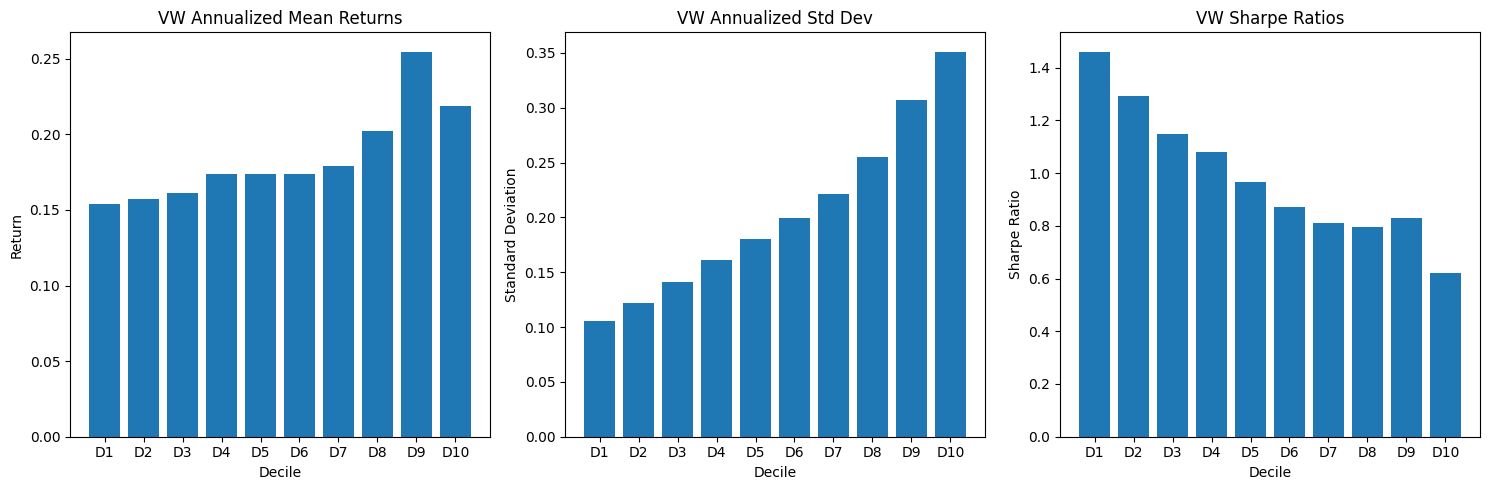

<BarContainer object of 10 artists>

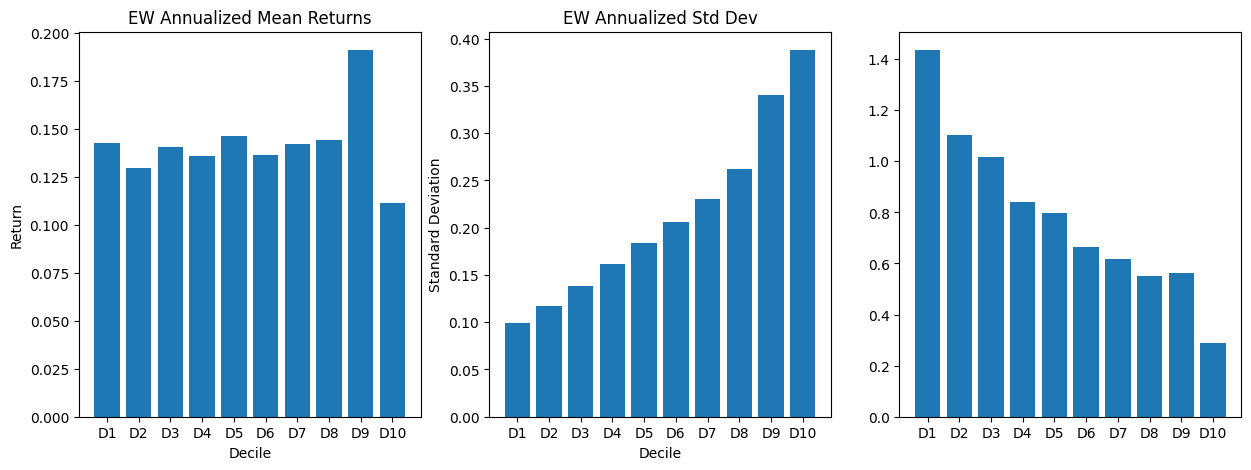

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Assume data is a DataFrame that contains the following columns:
# 'date': The date of the observation.
# 'beta': The beta of the stock.
# 'mcap': The market capitalization of the stock.
# 'Rn': The return of the stock.

# Function to annualize monthly returns
def annualize_return(monthly_return):
    return ((1 + monthly_return)**12 - 1)

# Function to compute Sharpe Ratio
def sharpe_ratio(mean_return, std_dev, risk_free_rate=0):
    return (mean_return - risk_free_rate) / std_dev

# Sort stocks into deciles based on their beta each month
data = data.dropna(subset=['beta']).copy()
data['beta_Q'] = data.groupby('date')['beta'].transform(lambda x: pd.qcut(x, 10, labels=False, duplicates='drop'))

# Market Weights within deciles
data['vw_Q'] = data['mcap'] / data.groupby(['date', 'beta_Q'])['mcap'].transform('sum')

# Value-Weighted Portfolios
data['beta_ret_vw'] = data['vw_Q'] * data['Rn']
ret_vw = data.groupby(['date', 'beta_Q'])['beta_ret_vw'].sum().reset_index()
vw_ret_mean = ret_vw.groupby('beta_Q')['beta_ret_vw'].mean()
vw_ret_std = ret_vw.groupby('beta_Q')['beta_ret_vw'].std()

# Equal-Weighted Portfolios
ret_ew = data.groupby(['date', 'beta_Q'])['Rn'].mean().reset_index()
ew_ret_mean = ret_ew.groupby('beta_Q')['Rn'].mean()
ew_ret_std = ret_ew.groupby('beta_Q')['Rn'].std()

# Annualize returns and standard deviations
vw_ret_mean_annual = annualize_return(vw_ret_mean)
ew_ret_mean_annual = annualize_return(ew_ret_mean)

vw_ret_std_annual = vw_ret_std * np.sqrt(12)
ew_ret_std_annual = ew_ret_std * np.sqrt(12)

# Calculate Sharpe Ratios
vw_sharpe_ratios = sharpe_ratio(vw_ret_mean_annual, vw_ret_std_annual)
ew_sharpe_ratios = sharpe_ratio(ew_ret_mean_annual, ew_ret_std_annual)

# Plotting the results
deciles = ['D' + str(x) for x in range(1, 11)]

plt.figure(figsize=(15, 5))

# Plot Value-Weighted Annualized Mean Returns
plt.subplot(1, 3, 1)
plt.bar(deciles, vw_ret_mean_annual)
plt.title('VW Annualized Mean Returns')
plt.xlabel('Decile')
plt.ylabel('Return')

# Plot Value-Weighted Annualized Standard Deviations
plt.subplot(1, 3, 2)
plt.bar(deciles, vw_ret_std_annual)
plt.title('VW Annualized Std Dev')
plt.xlabel('Decile')
plt.ylabel('Standard Deviation')

# Plot Value-Weighted Sharpe Ratios
plt.subplot(1, 3, 3)
plt.bar(deciles, vw_sharpe_ratios)
plt.title('VW Sharpe Ratios')
plt.xlabel('Decile')
plt.ylabel('Sharpe Ratio')

plt.tight_layout()
plt.show()

plt.figure(figsize=(15, 5))

# Plot Equal-Weighted Annualized Mean Returns
plt.subplot(1, 3, 1)
plt.bar(deciles, ew_ret_mean_annual)
plt.title('EW Annualized Mean Returns')
plt.xlabel('Decile')
plt.ylabel('Return')

# Plot Equal-Weighted Annualized Standard Deviations
plt.subplot(1, 3, 2)
plt.bar(deciles, ew_ret_std_annual)
plt.title('EW Annualized Std Dev')
plt.xlabel('Decile')
plt.ylabel('Standard Deviation')

# Plot Equal-Weighted Sharpe Ratios
plt.subplot(1, 3, 3)
plt.bar(deciles, ew_sharpe_ratios)


*c)*

In [13]:
# Weights
data['z'] = data.groupby('date')['beta'].transform(lambda x: x.rank())
data['z_'] = data['z']-data.groupby('date')['z'].transform('mean')
data['k'] = np.abs(data['z_'])
data['k'] = 2/data.groupby('date')['k'].transform('sum')
data['w_H'] = data['k'] * data['z_'] * (data['z_']>0)
data['w_L'] = -data['k'] * data['z_'] * (data['z_']<0)

# Weighted returns and beta
data['beta_H'] = data['w_H'] * data['beta']
data['beta_L'] = data['w_L'] * data['beta']
data['R_H'] = data['w_H'] * data['Rn']
data['R_L'] = data['w_L'] * data['Rn']
data['R_H_e'] = data['w_H'] * data['Rn_e']
data['R_L_e'] = data['w_L'] * data['Rn_e']




d)

In [14]:
BAB = data.groupby('date')[['R_H','R_L','R_H_e','R_L_e','beta_H','beta_L']].sum().reset_index()

BAB['BAB2'] = BAB['R_L_e']/BAB['beta_L'] - BAB['R_H_e']/BAB['beta_H']

In [16]:
BAB_final = BAB.drop(columns=['R_H','R_L','R_H_e','R_L_e','beta_H','beta_L'])
BAB_final['date'] = BAB_final['date'].dt.strftime('%Y-%m')
BAB_final['BAB'] = BAB_final['BAB2']
BAB_final = BAB_final.drop(columns=['BAB2'])

In [23]:
BAB_final.to_parquet('BAB_final.parquet')


In [ ]:
# Merge Market and Risk free Rate
tmp = pd.merge(BAB,data[['date','Rm_e']].drop_duplicates(), on=['date'], how='left')
tmp['const'] = 1

# Alpha and Beta
import statsmodels.api as sm
tmp = tmp.dropna()
OLS_Reg = sm.OLS(tmp['BAB2'], tmp[['const','Rm_e']]).fit()

Alpha_bab = OLS_Reg.params[0]*12
idio_vol = (tmp['BAB2']-OLS_Reg.predict()).std()*np.sqrt(12)
market_rp = tmp['Rm_e'].mean()*12
market_vol = tmp['Rm_e'].std()*np.sqrt(12)
beta_bab = OLS_Reg.params[1]

print('Annualized Alpha of BAB factor: ', Alpha_bab, OLS_Reg.tvalues[0])
print('Sharpe Ratio of BAB factor: ',tmp['BAB2'].mean()/tmp['BAB2'].std()*np.sqrt(12))
print('Idiosyncatic volatility: ',idio_vol)
print('Beta BAB: ',beta_bab)
print('Market Risk Premium: ',market_rp)
print('Market Volatility: ',market_vol)

Annualized Alpha of BAB factor:  0.11846480382496943 6.555918358878368
Sharpe Ratio of BAB factor:  0.7617003507156583
Idiosyncatic volatility:  0.13290362050544063
Beta BAB:  -0.2157029658827404
Market Risk Premium:  0.0644341716450973
Market Volatility:  0.15941410983233564


In [ ]:
data.to_parquet('stock_data_part1.parquet')


In [ ]:
data = pd.read_parquet('stock_data_part1.parquet')

In [ ]:
data.columns

Index(['permno', 'date', 'Rn', 'shrout', 'prc', 'siccd', 'Rm', 'rf', 'mcap',
       'mcap_l', 'Rn_f', 'const', 'Rn_e', 'Rm_e', 'w_m', 'beta', 'beta_Q',
       'vw_Q', 'beta_ret_vw', 'z', 'z_', 'k', 'w_H', 'w_L', 'beta_H', 'beta_L',
       'R_H', 'R_L', 'R_H_e', 'R_L_e'],
      dtype='object')

In [24]:
!git commit -m 'update adam'

---
# Momentum Strategy (Mom)

---
# Idiosyncratic Volatility Strategy (IV)

---
# Optimal Fund Portfolio Return (STRAT)

---
# Performance and risk analysis for the Fund strategy

---
# Industry neutral strategy